In [1]:
import pandas as pd
import sklearn, math
from collections import OrderedDict
import skill_metrics as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.lines import Line2D
import xarray as xr

In [ ]:
base_dir = './WEM/Paper/'
sea_lat=(5, 25)
sea_lon= (95, 110)
time_slice=('1997-01-01', '2015-12-31')
# extract data from aphrodite, cpc and chirps
aphro_nc=xr.open_dataset(base_dir+ 'aphro_MA.nc').sel(longitude=slice(95, 110), latitude= slice(5, 25), time= slice('1997-01-01', '2015-12-31')).rename({'latitude':'lat','longitude':'lon'})
chirps_nc=xr.open_mfdataset(base_dir +'chrips_25/*.nc').sel(longitude=slice(95, 110), latitude= slice(5, 25), time= slice('1997-01-01', '2015-12-31')).rename({'latitude':'lat','longitude':'lon'})
cpc_nc=xr.open_dataset(base_dir+'rotated1.nc').sel(lon=slice(95, 110), lat= slice(25, 5), time= slice('1997-01-01', '2015-12-31'))
cru_nc = xr.open_dataset('./CRU/precip.nc').sel(lon=slice(95, 110), lat= slice(5, 25), time= slice('1997-01-01', '2015-12-31')).rename_vars({'pre':'precip'})
gpcc_nc= xr.open_mfdataset('./GPCC/*.nc').sel(lon=slice(95, 110), lat= slice(25,5), time= slice('1997-01-01', '2015-12-31'))#.rename_vars({'pre':'precip'})
saobs_nc=(xr.open_mfdataset('./Sa_obs/precip.nc').sel(longitude=slice(95, 110), latitude= slice(5, 25), time= slice('1997-01-01', '2015-12-31')).rename({'latitude':'lat','longitude':'lon'})
                                                                                                    .rename_vars({'rr':'precip'}))

In [ ]:
all_dataset =[aphro_nc, chirps_nc, cpc_nc, cru_nc, gpcc_nc, saobs_nc]
dataset_folders= ['Aphrodite', 'Chirps', 'CPC','CRU','GPCC','Sa_obs']



In [ ]:
#save sliced files to individual dataset folder under precip
all_dataset =[aphro_nc, chirps_nc, cpc_nc, cru_nc, gpcc_nc, saobs_nc]
dataset_folders= ['Aphrodite', 'Chirps', 'CPC','CRU','GPCC','Sa_obs']
out_folder='/precip/'
[my_dataset.to_netcdf(path='./'+in_folder+'/'+in_folder+'_SEA.nc', engine="h5netcdf") for my_dataset, in_folder in zip(all_dataset[1:], dataset_folders[1:])]

In [ ]:
# read remaining dataset: TRMM, CMORPH 
cmorph = xr.open_dataset('./CMORPH/Cmorph.nc').sel(lon=slice(95, 110), lat= slice(5, 25), time= slice('1997-01-01', '2015-12-31')).rename({'prcp':'precip'})

cmorph

In [ ]:
import glob
# This function takes TRMM datasetfile list and add time dimension to each dataset and returns the concatenated sliced dataset of the study area
trmm_file_list= glob.glob('./TRMM/*.nc4')

#time= [pd.date_range(start='1998-01-01', end='2019-12-30',freq='D')]


def trmm_batchprocessing(filelist):
    time= [pd.date_range(start='1998-01-01', end='2019-12-30',freq='D')]
    updated_list=[]
    for i, file in enumerate(trmm_file_list):
        trmm = xr.open_dataset(file).load()
        variables=['precipitation'] # to select dataset with precipiation variables
        trmm_da=trmm.expand_dims("time").assign_coords(time=('time',[time[0][i],])).sel(lon=slice(95, 110), lat= slice(5, 25))[variables]
        #trmm_da.close()
        trmm_da.to_netcdf('./TRMM/trmm_processed/'+file, engine='scipy')
        #updated_list.append(trmm_da)
    #trmm_SEA=xr.open_mfdataset(updated_list, concat_dim='time')
    
                                                                        
#, concat_dim='time').sel(lon=slice(95, 110), lat= slice(5, 25), time= slice('1997-01-01', '2015-12-31'))
#help(xr.open_mfdataset)
trmm_batchprocessing(trmm_file_list)

In [ ]:
trmm_nc= xr.open_mfdataset('./TRMM/trmm_processed/TRMM/*.nc4', concat_dim='time').rename({'precipitation':'precip'})

In [ ]:
#trmm_nc= trmm_nc.sel(time=slice('1998-01-01', '2015-12-31'))
gridded_to_df(cmorph, 'cmorph').to_excel('./gridded_excel_files/cmorph.xlsx')
#gridded_to_df(trmm_nc, 'trmm').to_excel('./gridded_excel_files/trmm.xlsx')
#trmm_nc

In [ ]:
# export all dataset to excel as xarray data set loading and extraction takes longer time
[gridded_to_df(dataset, name).to_excel('./gridded_excel_files/'+name+'.xlsx') for dataset, name in zip(all_dataset, dataset_folders)]

In [2]:
# def function to read excel files with required formatting
def read_excel(filename, sheet_name, name=""):
    path='./gridded_excel_files/'
    columns_toremove=['Thangon_'+name,'Veunkham_'+name]
    
    if sheet_name in ['Stations','Precipitation']:
        df1 = pd.read_excel(path+filename, sheet_name=sheet_name, header=0, engine='openpyxl').sort_index(axis=1)
        return df1
    else:
        df2 = pd.read_excel(path+filename, sheet_name=sheet_name, header=0, engine='openpyxl').sort_index(axis=1)
        print(columns_toremove)
        df2.drop(['Thangon_'+name,'Veunkham_'+name, 'Phonehong_'+name], axis=1, inplace=True)
        return df2


In [3]:
stations = read_excel('Station_data_1997_2019.xlsx', sheet_name = 'Stations')
observed= read_excel('Station_data_1997_2019.xlsx', sheet_name = 'Precipitation').set_index('Date').rename_axis('time').dropna()
cpc = read_excel('cpc.xlsx', sheet_name = 'Sheet1', name='CPC').set_index('time').loc['1998-01-01':'2015-12-31', :]
aphrodite=read_excel('Aphrodite.xlsx', sheet_name = 'Sheet1', name='Aphrodite').set_index('time').loc['1998-01-01':'2015-12-31', :]
chirps= read_excel('chirps.xlsx', sheet_name = 'Sheet1',name='Chirps').set_index('time').loc['1998-01-01':'2015-12-31', :]
cru=read_excel('CRU.xlsx', sheet_name = 'Sheet1', name='CRU').set_index('time').loc['1998-01-01':'2015-12-31', :].loc['1998-01-01':'2015-12-31', :]
gpcc=read_excel('GPCC.xlsx', sheet_name = 'Sheet1', name='GPCC' ).set_index('time').loc['1998-01-01':'2015-12-31', :]
saobs=read_excel('Sa_obs.xlsx', sheet_name = 'Sheet1',name='Sa_obs').set_index('time').loc['1998-01-01':'2015-12-31', :]
# cmorph=read_excel('cmorph.xlsx', sheet_name = 'Sheet1', name='cmorph').set_index('time').loc['1998-01-01':'2015-12-31', :]
# trmm= read_excel('trmm.xlsx', sheet_name = 'Sheet1', name='trmm').set_index('time').loc['1998-01-01':'2015-12-31', :]
# trmm

['Thangon_CPC', 'Veunkham_CPC']
['Thangon_Aphrodite', 'Veunkham_Aphrodite']
['Thangon_Chirps', 'Veunkham_Chirps']
['Thangon_CRU', 'Veunkham_CRU']
['Thangon_GPCC', 'Veunkham_GPCC']
['Thangon_Sa_obs', 'Veunkham_Sa_obs']


In [4]:
observed= observed.loc['1998-01-01':'2015-12-31', :]
observed.head()

,Ban_Hinheup,Napheng,Naphok,Pakkanhoung,Vientaine
time,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0
1998-01-02,0.0,0.0,0.0,0.0,0.0
1998-01-03,0.0,0.0,0.0,0.0,0.0
1998-01-04,0.0,0.0,0.0,0.0,0.0
1998-01-05,0.0,0.0,0.0,0.0,0.0


In [5]:
# merged dataset
datasets=[observed,aphrodite, chirps, cru, cpc, gpcc, saobs]
#first resample into month then concat
monthly_ds =[grid_dataset.resample('M').sum() for grid_dataset in datasets]
merged_ds= pd.concat(monthly_ds, axis=1).sort_index(axis=1)
merged_ds.head()

,Ban_Hinheup,Ban_Hinheup_Aphrodite,Ban_Hinheup_CPC,Ban_Hinheup_CRU,Ban_Hinheup_Chirps,Ban_Hinheup_GPCC,Ban_Hinheup_Sa_obs,Napheng,Napheng_Aphrodite,Napheng_CPC,...,Pakkanhoung_Chirps,Pakkanhoung_GPCC,Pakkanhoung_Sa_obs,Vientaine,Vientaine_Aphrodite,Vientaine_CPC,Vientaine_CRU,Vientaine_Chirps,Vientaine_GPCC,Vientaine_Sa_obs
time,,,,,,,,,,,,,,,,,,,,,
1998-01-31,0.0,0.000000,0.820713,6.000000,6.313801,0.150000,0.000000,0.0,0.000000,0.431915,...,0.838577,0.000000,0.000000,0.0,0.410647,0.393409,3.900000,0.000000,0.050000,0.000000
1998-02-28,1.0,5.399670,3.646337,21.800001,16.249173,9.550000,5.200000,7.0,4.191278,11.726746,...,14.315714,5.520000,5.100000,7.7,12.480276,19.988456,35.600002,19.646811,15.880000,9.500000
1998-03-31,1.0,18.508904,31.401615,38.700001,64.677391,28.900000,18.900001,78.6,46.109046,31.928562,...,72.578098,24.270000,26.200001,34.5,31.468200,38.600040,32.600002,48.740155,47.400002,7.800000
1998-04-30,16.0,94.424613,68.917504,126.300003,237.501991,149.050003,152.700001,40.3,36.486790,57.770849,...,151.132870,73.430000,115.500000,78.5,67.943812,51.402626,70.700005,79.426828,64.199997,59.000001
1998-05-31,156.0,196.601343,138.009992,180.300003,286.990159,242.419998,369.500007,234.9,159.560648,168.144202,...,240.294456,236.589996,303.000004,143.9,149.692755,163.169531,184.000000,132.194201,163.119995,179.900003


In [6]:
#rowwise concatenation
datasets=[observed,aphrodite, chirps, cru, cpc, gpcc, saobs]
# change dataset columns to observed
dataset_m =[dataset.set_axis(datasets[0].columns, axis=1) for dataset in datasets]

names=['Observed','Aphrodite','Chirps','CRU','CPC', 'GPCC', 'SAOBS']

monthly_ds=[grid_dataset.resample('M').sum() for grid_dataset in dataset_m]
merged_ds=pd.concat(monthly_ds, axis=0, keys=names)
merged_ds.head()

Ban_Hinheup  Napheng  Naphok  Pakkanhoung  Vientaine
         time                                                            
Observed 1998-01-31          0.0      0.0     0.0          0.0        0.0
         1998-02-28          1.0      7.0    11.0          0.0        7.7
         1998-03-31          1.0     78.6    62.2         55.0       34.5
         1998-04-30         16.0     40.3    39.0        100.0       78.5
         1998-05-31        156.0    234.9   164.9        235.0      143.9

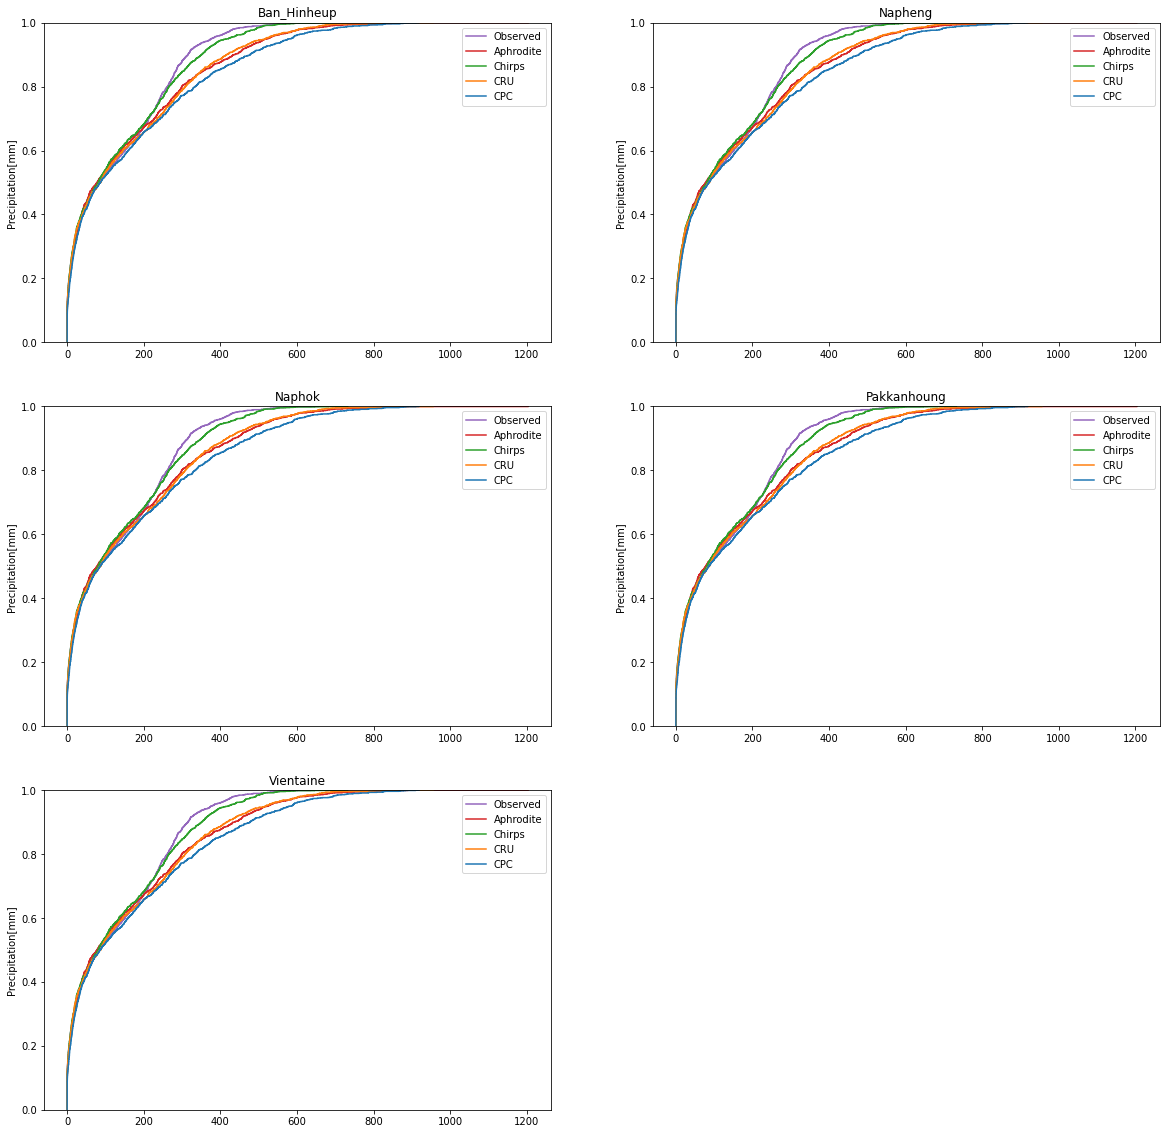

In [7]:
import seaborn as sns
# cdf plot
# plot cdf
def cdf_plots(ds, rows, cols, names,enum):
    fig, axs = plt.subplots(rows, cols, figsize=(20,20))
    for ax,name, col in zip(axs.flatten(), names, ds.columns):
        
        sns.ecdfplot(data= ds, legend='auto', ax=ax)
        #sns.ecdfplot(data=ds, x=ds.iloc[:,j+1], legend='auto', ax=ax)
        ax.set_ylabel('Precipitation[mm]')
        ax.set_title(col)
        #ax.legend(['Observed','Aphrodite','Chirps','CRU','CPC', 'GPCC', 'SAOBS','cmorph','trmm'])
        ax.legend(names)
        plt.subplots_adjust()
    #return fig
    # decide number to delete from subplot
    num_axs_todel= rows*cols-len(ds.columns)
    [axs[-1, enum].set_visible(False) for num in range(-num_axs_todel, 0)]
    #fig.delaxes(axs[ :,-3:])
cdf_plots(merged_ds, 3, 2, names,1)



In [8]:
ord_dic={}
ord_dic['bias']=sm.bias(merged_ds.loc[names[0]], merged_ds.loc[names[1]])
ord_dic

{'bias': Ban_Hinheup   -25.534309
 Napheng        25.339578
 Naphok          4.969820
 Pakkanhoung    21.996320
 Vientaine      13.055080
 dtype: float64}

In [9]:
# define function to calculate taylor statistics and results stats in both dataframe and stats

def sm_stats(ds, names):
    #create empty dictionary to hold the statistics
    dataset_stat ={}
    taylor_stat_dic={}
    result_stat=[]
    for i in range(0, len(names)):
        stats = OrderedDict()
        taylor_stat= OrderedDict()
        # remove nan from obs 
        
        ds.loc[names[i]].dropna(inplace=True)
        ref = ds.loc[names[0]]
        #print(ref)
        pred = ds.loc[names[i]]
        stats['bias'] = sm.bias(pred, ref)
        stats['rmsd'] = sm.rmsd(pred, ref)
        stats['crmsd'] =  sm.centered_rms_dev(pred, ref)
        stats['sdev'] =  pred.std()
        ccoef =pred.corrwith(ref, axis=0)
        stats['r'] = ccoef
        stats['ss'] = sm.skill_score_murphy(pred, ref)
        dataset_stat[names[i]] = stats
        
        #taylorstat
        taylor_stat['crmsd'] = {col_ty: [ele_pred, ele_ref] for ele_pred, ele_ref, col_ty in zip(sm.centered_rms_dev(ref, ref).to_numpy(), sm.centered_rms_dev(pred, ref).to_numpy(), ref.columns)}
        taylor_stat['sdev'] = {col_ty: [ele_pred, ele_ref] for ele_pred, ele_ref, col_ty in zip(ref.std().to_numpy(), pred.std().to_numpy(), ref.columns)}
        #print(taylor_stat['sdev'])[ref.corrwith(ref, axis=0), ccoef]
        taylor_stat['r'] = {col_ty: [ele_pred, ele_ref] for ele_pred, ele_ref, col_ty in zip(ref.corrwith(ref, axis=0).to_numpy(), pred.corrwith(ref, axis=0).to_numpy(), ref.columns)}
        taylor_stat_dic[names[i]] = taylor_stat
        
        result_stat.append(pd.DataFrame(stats))
        #result=pd.concat(stats, index=['bias','rmsd','crmsd','sdev','r','ss'], keys=names)
        
    return dataset_stat, pd.concat(result_stat, keys= dataset_stat.keys()),taylor_stat_dic

In [10]:
stats_dic, stats_df,taylor_stat_dic= sm_stats(merged_ds, names)
taylor_stat_dic['Observed']

OrderedDict([('crmsd',
              {'Ban_Hinheup': [0.0, 0.0],
               'Napheng': [0.0, 0.0],
               'Naphok': [0.0, 0.0],
               'Pakkanhoung': [0.0, 0.0],
               'Vientaine': [0.0, 0.0]}),
             ('sdev',
              {'Ban_Hinheup': [188.89178660188037, 188.89178660188037],
               'Napheng': [223.38129701271282, 223.38129701271282],
               'Naphok': [154.37540847584634, 154.37540847584634],
               'Pakkanhoung': [216.17334882507618, 216.17334882507618],
               'Vientaine': [142.8056100163524, 142.8056100163524]}),
             ('r',
              {'Ban_Hinheup': [0.9999999999999997, 0.9999999999999997],
               'Napheng': [1.0, 1.0],
               'Naphok': [0.9999999999999998, 0.9999999999999998],
               'Pakkanhoung': [1.0, 1.0],
               'Vientaine': [1.0000000000000009, 1.0000000000000009]})])

C:\Users\USER\python\lib\site-packages\skill_metrics\taylor_diagram.py:84: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(CORs)


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

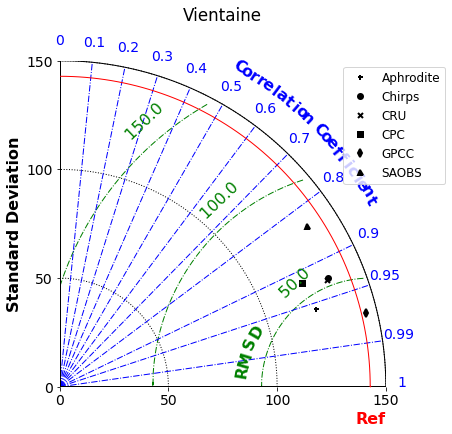

In [12]:
from matplotlib import rcParams

rcParams["figure.figsize"] = [8, 6]
rcParams['lines.linewidth'] = 1 # line width for plots
rcParams.update({'font.size': 14}) # font size of axes text

taylor_diag=stats_df.swaplevel(1,0).sort_index(level=0, sort_remaining=False)
markerlbl = list(taylor_diag.index.get_level_values(1).unique())
stations_taylor= list(taylor_diag.index.get_level_values(0).unique())
markercolor=['r','g','b','c','y','k','br','c']
dict_mk={lbl: markercol for lbl, markercol in zip(markerlbl, markercolor)}
for i, station in enumerate(stations_taylor):
    plt.figure(figsize=(8,6))    
    sm.taylor_diagram(taylor_diag.loc[station]['sdev'].to_numpy(),taylor_diag.loc[station]['crmsd'].to_numpy(),taylor_diag.loc[station]['r'].to_numpy(),
                      markerLabel=markerlbl, alpha = 1, markerLegend='on', markerColor='k',
                      colRMS='g',  styleRMS='-.', widthRMS=1.0, titleRMS = 'on', showlabelsRMS = 'on', overlay='off',
                       markerSize=5,  numberPanels=1,
                     styleObs='-', colOBS='r', markerobs='x', titleOBS='Ref', checkstats='on',)
    plt.title(station, pad=40)#, fontdict={'fontSize':20})
    #plt.savefig('./figures/Taylor_diagram_25052021{0}.png'.format(station),dpi=200)
    if i <4:
        plt.clf()
    else:
        plt.show()
    #plt.clf()


In [13]:
def rank_dataset(monthly_stats):
    # seperate observed and gridded datasets stats
    cols_to_rem = len(list(monthly_stats.index.get_level_values(1).unique()))
    withoutobs_df = monthly_stats.iloc[cols_to_rem:]
    dataset_labels = list(withoutobs_df.index.get_level_values(0).unique())
    #normalized obs 
    normalized_obs = monthly_stats.loc['Observed'].apply(lambda x : abs(x)/sum(abs(x)) if x.all()>0 else x)
    #swap level to hold data at station level
    lvlswapped=withoutobs_df.swaplevel(1,0).sort_index(axis=0, level=0)
    # normalize 
    normalized_df =lvlswapped.groupby(level=0).transform(lambda x: abs(x)/(sum(abs(x))))
    # calculate log matrix of normalized dataset
    log_mx =normalized_df.applymap(np.log)
    #multiply normalized matrix with it logmatrix and then sum
    uncertainty_mx = normalized_df.mul(log_mx)
    entropy_mx = -1/(np.log(len(dataset_labels))) *uncertainty_mx.groupby(level=[0]).transform('sum')
    diversification_mx = 1- entropy_mx
    
    # calculate weight matrix
    weight_mx=diversification_mx.apply(lambda x: x/sum(x), axis=1)
    
    # compute compromise programming
    ranked_dataset= compromise_prog_rank (normalized_df, normalized_obs, dataset_labels, weight_mx)
    return ranked_dataset
        
def compromise_prog_rank(normalized_griddedstats, normalized_obsstat, dataset_labels, weight_matrix):
    distance={}
    weight_matrix= weight_matrix.swaplevel(0,1).sort_index()
    for_eachds=normalized_griddedstats.swaplevel(1,0).sort_index()
    for indx in dataset_labels:
        distance[indx]=(for_eachds.loc[indx]-normalized_obsstat).applymap(np.square)
    distance_df = pd.concat(distance)
    #my_weights= my_weights.swaplevel(0,1).sort_index()
    Lp= distance_df.mul(weight_matrix).sum(axis=1)
    return Lp.unstack().applymap(np.sqrt).rank()

rk_ds = rank_dataset(stats_df)
ranked_meanpcp=rk_ds.reset_index()
ranked_meanpcp['data']="MeanPcp"
ranked_meanpcp = ranked_meanpcp.set_index(['data','index'])
ranked_meanpcp=ranked_meanpcp.rename_axis([None, None])
#stats_df.to_excel('Quantitative_stats_25052021.xlsx', sheet_name='Continuous Stat')

In [14]:
ranking_list=stats_df.iloc[5:]
#t=ranking_list.iloc[:,0].unstack()#.apply(lambda x : x/sum(x))
#t, print(t.apply(lambda x: x/sum(abs(x))))
ranking_list.head()
#ranking_list.to_excel('Quantitative_ranks_25052021.xlsx', sheet_name='rank Stat')

bias        rmsd      crmsd        sdev         r  \
Aphrodite Ban_Hinheup  25.534309   97.532341  42.096453  191.984462  0.877397   
          Napheng     -25.339578  109.960361  47.852245  159.256111  0.896129   
          Naphok       -4.969820   73.932077  32.988643  130.339141  0.878515   
          Pakkanhoung -21.996320  111.546546  48.905611  154.323079  0.877266   
          Vientaine   -13.055080   45.323792  19.410363  123.163424  0.957166   

                             ss  
Aphrodite Ban_Hinheup  0.733393  
          Napheng      0.757686  
          Naphok       0.770644  
          Pakkanhoung  0.733739  
          Vientaine    0.899269

In [15]:
# generate lengends for manual plot
import itertools
marker_kind = ['+','o','x','s','d','^','v','>','<']
colors_leg=['r','g','b','c','y',]#'y','m','brown','purple']
legend_list=[]
legend_list.append(Line2D([], [], marker='None', label='Stations', linestyle='None', markerfacecolor='None', markersize=14))
#append aphrodite manually
#aphrodite_leg=Line2D([], [], marker='s', color='r', label='Aphrodite', linestyle='None', markerfacecolor='r', alpha=0.8, markersize=10)
#legend_list.append(aphrodite_leg)
# append cpc legend manually
legend_list.append([Line2D([0], [0], marker='s', markeredgecolor=c, 
                           markerfacecolor=c, label=label, 
                           linestyle='None', markersize=10) for label, c in zip(datasets[0].columns.to_list(),colors_leg)])
flatten_list = lambda legend_list:[element for item in legend_list for element in flatten_list(item)] if type(legend_list) is list else [legend_list]
print(legend_list)
legend_list=flatten_list(legend_list)
# Use seperator
legend_list.append(Line2D([], [], marker='None', label='', linestyle='None', markerfacecolor='None', markersize=14))
legend_list.append(Line2D([], [], marker='None', label='Datasets', linestyle='None', markerfacecolor='None', markersize=10))
for marker, lbl in zip(marker_kind, stats_df.index.levels[0].to_list()):
    legend_list.append(Line2D([], [], color='k', marker=marker, linestyle='None',
                              markersize=10, label=lbl))
#legend_list   

[<matplotlib.lines.Line2D object at 0x000001D7448B71F0>, [<matplotlib.lines.Line2D object at 0x000001D74478BBE0>, <matplotlib.lines.Line2D object at 0x000001D74478BB80>, <matplotlib.lines.Line2D object at 0x000001D744789F30>, <matplotlib.lines.Line2D object at 0x000001D744789AE0>, <matplotlib.lines.Line2D object at 0x000001D74478A440>]]


C:\Users\USER\python\lib\site-packages\skill_metrics\taylor_diagram.py:84: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(CORs)


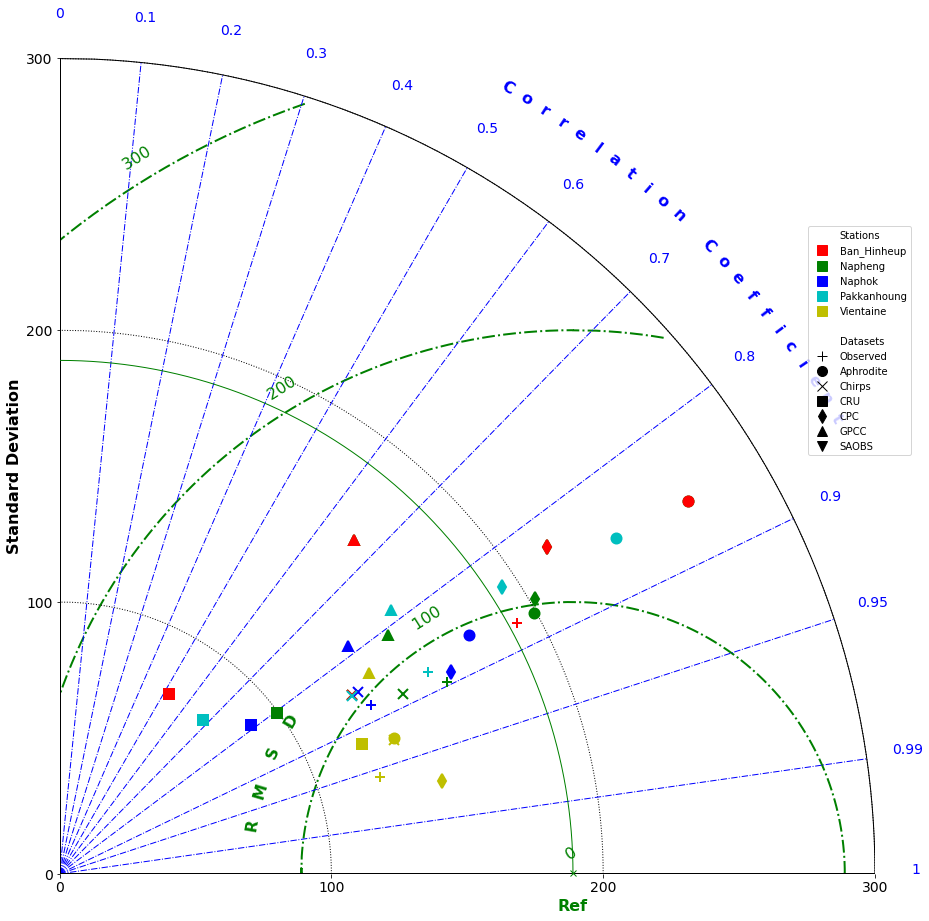

In [16]:
import importlib
importlib.reload(sm)
station_names= datasets[0].columns.to_list()
stats_dic, _sdf, taylor_stat_dics =sm_stats(merged_ds, names)
taylor_stat_dic= _sdf.swaplevel().groupby(level=[0,1]).max()

marker_labels=_sdf.index.levels[0].to_list()
colors=['r','g','b','c','y']
legend_labels={name: color for name, color in zip(station_names, colors)}
# try plotting taylor diagram
stat_param=['bias','rmsd','crmsd','sdev','r','ss']

fig, axs= plt.subplots(1, figsize=(15,15))

axs=sm.taylor_diagram(taylor_stat_dic.loc['Ban_Hinheup']['sdev'].to_numpy(),taylor_stat_dic.loc['Ban_Hinheup']['crmsd'].to_numpy(),taylor_stat_dic.loc['Ban_Hinheup']['r'].to_numpy(),
                      markerLabel=marker_labels, alpha = 1, markerLegend='on', markerColor='g',
                      colRMS='g',  styleRMS='-.', widthRMS=2.0, titleRMS = 'on', showlabelsRMS = 'on', tickRMS=range(0, 310, 100),
                       markerSize=10,  numberPanels=1,
                     styleObs='-', colOBS='g', markerobs='x', titleOBS='Ref', checkstats='off',)

for name, color in zip(station_names, colors):
    axs=sm.taylor_diagram(taylor_stat_dic.loc[name]['sdev'].to_numpy(),taylor_stat_dic.loc[name]['crmsd'].to_numpy(),taylor_stat_dic.loc[name]['r'].to_numpy(),
                       markerLabel=marker_labels, alpha =1, markerLegend='on', markerColor=color, 
                      colRMS='g',  styleRMS='-.', widthRMS=2.0, titleRMS = 'off', showlabelsRMS = 'off', overlay='on',
                     markerSize=10)
plt.legend(handles=legend_list, bbox_to_anchor=(1.05, 0.8),prop={'size':10})

#plt.savefig('./figures/Taylor_diagram_25052021.png',dpi=200)
plt.show()

In [24]:
import xclim as xc
#import xclim

In [21]:
import xarray as xr
#data_array={name: data.to_xarray() for name, data in zip(names,datasets)}

def delete_monthlyds(dfs, names):
    new_df=[]
    new_names=[]
    for df, name in zip(dfs, names):
        if len(df.index.day.unique())<28:
            del df
            del name
            
        else:
            df=df
            name=name
            new_df.append(df)
            new_names.append(name)
    return new_df, new_names
        


In [55]:
#from xclim.icclim import CDD, CWD, R10mm, R20mm, RX1day, RX5day #R95p, R99p
from xclim.indices import maximum_consecutive_dry_days as CDD, maximum_consecutive_wet_days as CWD, max_1day_precipitation_amount as RX1day
from xclim.indices import max_n_day_precipitation_amount as RX5day, daily_pr_intensity as R20mm
# define function that takes dataarray and calculates indices

indices =[CDD, CWD, R20mm, RX1day, RX5day] #95p, R99p]
    #indices_names= [indice.__name__ for indice in indices]
indices_names=['CDD','CWD','R20mm','RX1day','RX5day']
thresholds =['1mm/day','1mm/day','20 mm/day', None, 5]
# define a function that takes dataframe and converts it to xarray dataset and add units 
# then calculates xclim indices and returns extreme indices dataframe

def df_to_ds(dataset, names, indice, indice_name, threshold=None):
    # check each dataset for daily dataset and remove monthly dataset
    new_dataset, new_name=delete_monthlyds(dataset, names)
    ds= {name: dataset.to_xarray() for name, dataset in zip(new_name, new_dataset)}
    #create empty list to hold extreme indices for each dataframe
    
    dataset_wise=[]
    # add units to each data variables of ds
    for keys, dfs in ds.items():
        indices_result=[]
        for station_names in dfs.data_vars:
            da =dfs[station_names]
            da.attrs['units']='mm/day' #add unit to calculate indices

            # for each station calculate extreme indices and change to dataframe
            if indice_name =='RX5day':
                my_indices=indice(da, window= threshold).to_dataframe()
            elif indice_name =='RX1day':
                my_indices= indice(da).to_dataframe()
            else:
                my_indices=indice(da, thresh= threshold).to_dataframe()
            indices_result.append(my_indices)
            

            indices_df= pd.concat(indices_result, axis=1)
        dataset_wise.append(indices_df)
    final_output= pd.concat(dataset_wise, axis=0, keys= ds.keys())
    return final_output

In [56]:
extreme_indices ={indice_name:df_to_ds(dataset_m, names, indice, indice_name, thresh) for indice, indice_name, thresh in zip(indices, indices_names, thresholds)}
#df_to_ds(dataset_m, names, CDD, 'CDD')
extreme_indices['CDD'].index.levels[0]

Index(['Observed', 'Aphrodite', 'Chirps', 'CPC', 'SAOBS'], dtype='object')

In [57]:
#Boxplot for extreme indices
namngum_ei= pd.concat(extreme_indices)
namngum_ei.loc[['RX1day'],:]

Ban_Hinheup     Napheng      Naphok  Pakkanhoung  \
                time                                                           
RX1day Observed 1998-01-01    71.000000  104.800000   96.800000    91.000000   
                1999-01-01    87.000000  103.900000  102.500000   123.000000   
                2000-01-01    82.000000   91.800000   86.000000   259.000000   
                2001-01-01    71.000000  112.800000   71.700000   111.000000   
                2002-01-01    63.200000   42.000000  160.800000    79.000000   
...                                 ...         ...         ...          ...   
       SAOBS    2011-01-01    56.299999   50.799999   47.799999    53.000000   
                2012-01-01    34.100002   30.800001   33.200001    36.799999   
                2013-01-01    43.100002   35.500000   34.400002    38.600002   
                2014-01-01    30.100000   27.700001   27.300001    28.800001   
                2015-01-01    35.500000   34.600002   33.200001    30.500000   

                             Vientaine  
                time                    
RX1day Observed 1998-01-01  110.200000  
                1999-01-01  161.600000  
                2000-01-01  145.900000  
                2001-01-01   80.500000  
                2002-01-01   94.200000  
...                                ...  
       SAOBS    2011-01-01   61.700001  
                2012-01-01   30.400000  
                2013-01-01   34.200001  
                2014-01-01   31.300001  
                2015-01-01   32.100002  

[90 rows x 5 columns]

In [58]:
namngum_ei.loc[['RX5day'],:]

Ban_Hinheup     Napheng      Naphok  Pakkanhoung  \
                time                                                           
RX5day Observed 1998-01-01   155.000000  231.600000  223.900000   194.000000   
                1999-01-01   167.000000  225.900000  162.300000   204.000000   
                2000-01-01   166.000000  272.300000  187.900000   535.000000   
                2001-01-01   136.000000  240.700000  179.300000   174.000000   
                2002-01-01   119.000000  124.400000  221.900000   181.300000   
...                                 ...         ...         ...          ...   
       SAOBS    2011-01-01   175.000004  167.099999  162.100002   168.100001   
                2012-01-01    83.800001   86.600001   77.900002    81.800002   
                2013-01-01    93.200000   96.300001   92.200002    92.800000   
                2014-01-01    86.600002   97.300003   84.300002    86.900001   
                2015-01-01   106.700002  103.000005   93.300001    94.200003   

                             Vientaine  
                time                    
RX5day Observed 1998-01-01  173.000000  
                1999-01-01  261.700000  
                2000-01-01  218.200000  
                2001-01-01  207.900000  
                2002-01-01  156.600000  
...                                ...  
       SAOBS    2011-01-01  177.400002  
                2012-01-01   69.700000  
                2013-01-01  100.100002  
                2014-01-01   97.200002  
                2015-01-01   89.900001  

[90 rows x 5 columns]

In [59]:
namngum_ei_stack= namngum_ei.stack().reset_index().rename({'level_0':'EI','level_1':'Datasets','level_3':'Stations',0:'Rain'}, axis=1)
namngum_ei_stack.head()

,EI,Datasets,time,Stations,Rain
0,CDD,Observed,1998-01-01,Ban_Hinheup,42.0
1,CDD,Observed,1998-01-01,Napheng,74.0
2,CDD,Observed,1998-01-01,Naphok,40.0
3,CDD,Observed,1998-01-01,Pakkanhoung,83.0
4,CDD,Observed,1998-01-01,Vientaine,34.0


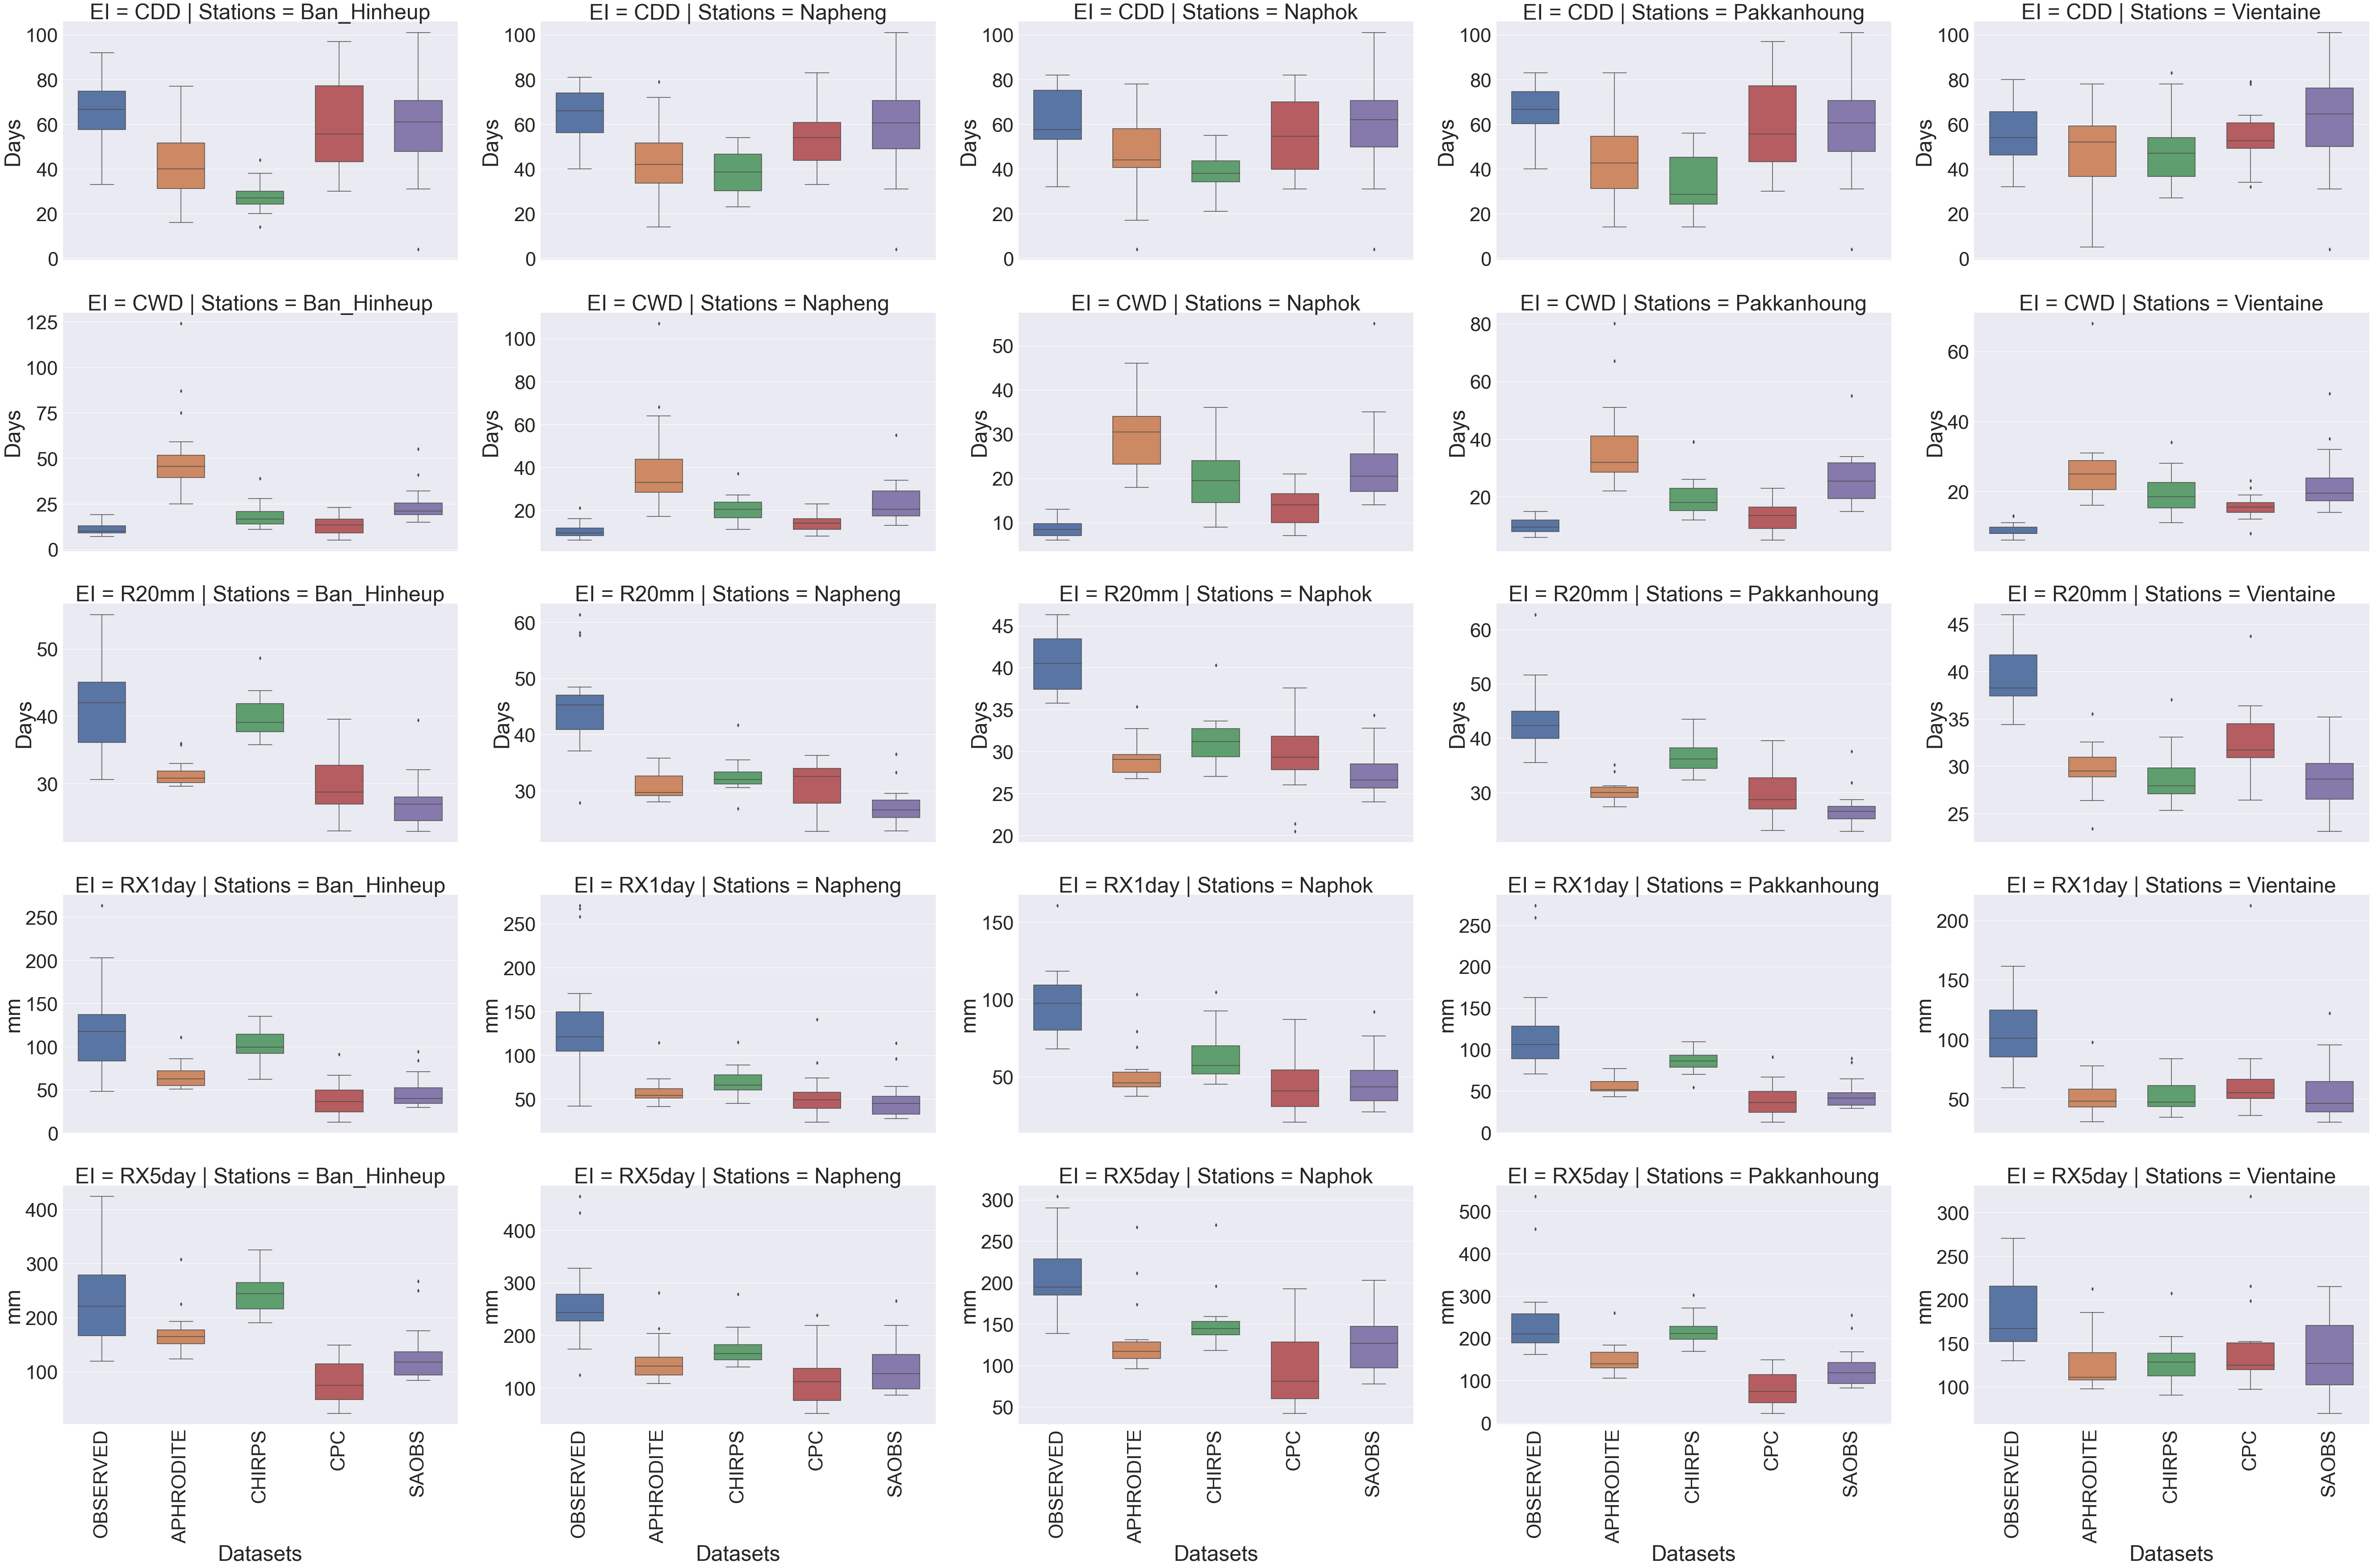

In [62]:
# boxplot 
import seaborn as sns
sns.set(font_scale=4)
sns.set_style('darkgrid') # set bg style of plot
g=sns.catplot(data=namngum_ei_stack, x='Datasets', y='Rain', 
            col='Stations',row='EI', hue='Datasets', 
            kind='box', height=10, aspect=1.5, width=0.6,
            sharey= False, dodge=False
           )
labels=['OBSERVED','APHRODITE','CHIRPS','CPC','SAOBS']
#units_ylabel=['Days','Days','Days','Days','mm','mm']*len(g.axes)
#units_ylabel
[ax.set_ylabel('Days') if i<15 else ax.set_ylabel('mm') for i, ax in enumerate(g.axes.flatten())  ]
g.set_xticklabels(labels, rotation=90)
plt.tight_layout()

In [63]:
daily_dataset_names= extreme_indices['CDD'].index.levels[0].unique().to_list()
#calculate statistics for each indices
extreme_indices_stats={indice_name:sm_stats(indices_dataset, daily_dataset_names) for indice_name, indices_dataset in extreme_indices.items()}
extreme_indices_statdf= {indice_name: extreme_indices_stats[indice_name][1] for indice_name in indices_names}
extreme_indices_statdf['CDD']
print(daily_dataset_names)

['Observed', 'Aphrodite', 'Chirps', 'CPC', 'SAOBS']


In [64]:
# Rank dataset
idx=pd.IndexSlice

indices_stat_wo_obs={indice_name: extreme_indices_statdf[indice_name] for indice_name in indices_names}
#indices_stat_wo_obs={indice_name: extreme_indices_statdf[indice_name].loc[idx['aphrodite':, :],:] for indice_name in indices_names}
w_ei ={indice_name: rank_dataset(indices_stat) for indice_name, indices_stat in indices_stat_wo_obs.items()}
ranked_ds_ei=pd.concat(w_ei)
ranked_ds_inc_eiandobs = pd.concat([ranked_meanpcp,ranked_ds_ei] )
#ranked_ds_inc_eiandobs.to_excel('Indices_wise_Ranked_dataset.xlsx', sheet_name='indices_ranked')

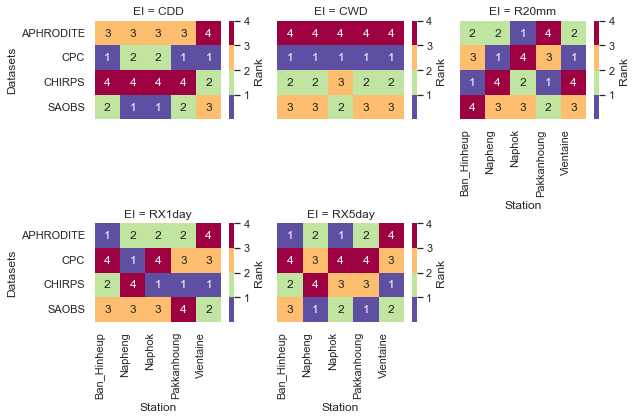

In [87]:
#heatmap
heat_ds= ranked_ds_ei.stack().reset_index().rename({'level_0':'EI','level_1':'Datasets','level_2':'Station',0:'Rank'}, axis=1)
heat_ds
sns.set(font_scale=1)
xlabels= np.unique(heat_ds.Station).tolist()
ylabels= np.unique(heat_ds.Datasets).tolist()
ylabels=[ylab.upper() for ylab in ylabels]
def facet(data,color):
    data = data.pivot(index="Datasets", columns='Station', values='Rank')
    heatplt = sns.heatmap(data, cbar=True, annot=True, cmap='Spectral_r',cbar_kws={'ticks':[i+1 for i in range(4)],'label':'Rank','boundaries':[0,1,2,3,4], 'values':[1,2,3,4],'spacing':'proportional'})
    heatplt.set_xticks(range(len(xlabels)))
    heatplt.set_xticklabels(xlabels, ha='right', rotation_mode='anchor')
    heatplt.set_yticklabels(ylabels, ha='right',rotation='horizontal', rotation_mode='anchor')
heatplt= sns.FacetGrid(data=heat_ds, col='EI', col_wrap=3)
heatplt.map_dataframe(facet)
plt.tight_layout()
#plt.savefig('./namngum_ranking_heatmaps.png', dpi=600)

In [88]:
# sum indicator wise then rank again

final_ranked_data = ranked_ds_inc_eiandobs.swaplevel().unstack().sum(level=0, axis=1)
#final_ranked_data = ranked_ds_inc_eiandobs.swaplevel().sum(level=0)
final_reranked_data= final_ranked_data.rank(method="min")
#final_reranked_data
final_reranked_data.head()#.to_excel('Ranked_dataset.xlsx', sheet_name='Final_Ranked_dataset')

C:\Users\USER\AppData\Local\Temp/ipykernel_65716/2971974924.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  final_ranked_data = ranked_ds_inc_eiandobs.swaplevel().unstack().sum(level=0, axis=1)


,Ban_Hinheup,Napheng,Naphok,Pakkanhoung,Vientaine
Aphrodite,3.0,4.0,3.0,5.0,6.0
CPC,5.0,3.0,6.0,6.0,4.0
CRU,2.0,2.0,1.0,2.0,2.0
Chirps,4.0,6.0,5.0,3.0,3.0
GPCC,1.0,1.0,2.0,1.0,1.0


In [89]:
# plot boxplot for each station
import seaborn as sns

def eval_plots(extreme_indices, rows, cols, leg_name):
    plot_indices= extreme_indices.reset_index()
    plt.close('all')
    fig, axs = plt.subplots(rows, cols, figsize=(15,10))
    for col,ax in zip(extreme_indices.columns, axs.flatten()):
        
        #sns.boxplot(data= [ds1.loc[plot_rows][j], ds2.loc[plot_rows][k], ds3.loc[plot_rows][l],ds4.loc[plot_rows][m]], orient='v', ax=ax)
        sns.boxplot(x='level_0', y=col, data=plot_indices, ax=ax)
        #ax.set_xticklabels(leg_name)
        ax.set_ylabel(leg_name, fontsize=16)
        ax.set_xlabel("")
        ax.set_title(col, fontsize=18)
        #ax.legend(['Observed','CPC', 'Aphrodite'])
        
        plt.subplots_adjust()
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30, fontsize=16)
    num_axs_todel= rows*cols-len(extreme_indices.columns)
    [axs[-1, num].set_visible(False) for num in range(-num_axs_todel,-0)]   
    return fig 

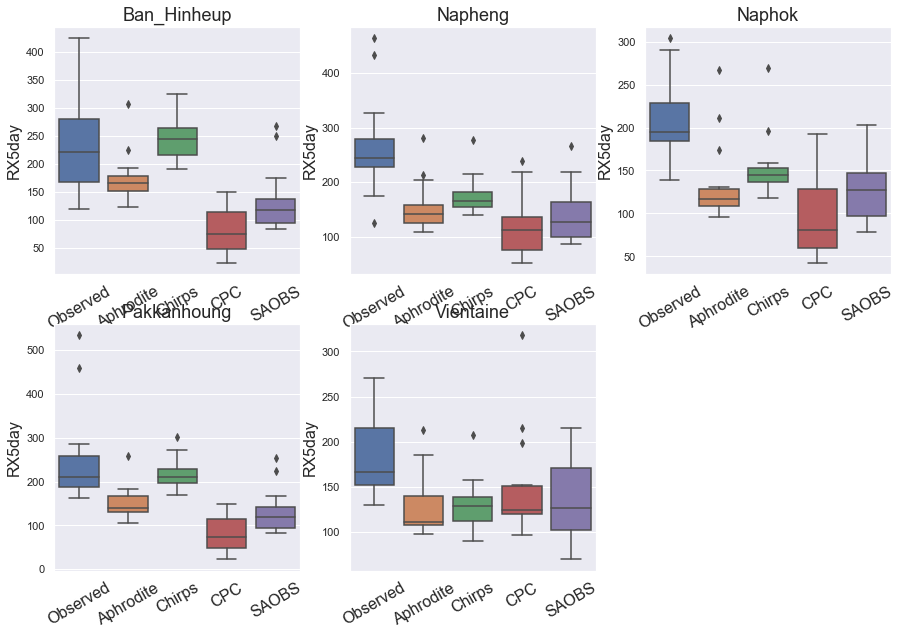

In [90]:
for ext_ind in extreme_indices.keys():
    
    plot = eval_plots(extreme_indices[ext_ind], 2, 3, ext_ind)
   # plot.savefig('./figures/{0}.png'.format(ext_ind), dpi=100,orientation='potrait',pad_inches=0.05)

In [91]:
# calculate  POD, FARR
def performance_measure(df1, df2):
    hits={}
    misses={}
    falseal={}
    for col1, col2 in zip(df1.columns, df2.columns):
        hit=[]
        miss=[]
        fa=[]
        #calculate hits misses and false alarm
        t=0.1 # mm for threshold rainfall
        for i in df1.index:
            result1 = df1.loc[i, col1]>=t and df2.loc[i, col2]>=t
            result2 = df1.loc[i, col1]>=t and df2.loc[i, col2]<t
            result3 =df1.loc[i, col1]<t and df2.loc[i, col2]>=t
            hit.append(result1)
            miss.append(result2)
            fa.append(result3)
       # res.append(pd.DataFrame(result)) #, index='time', columns=[col1]))
        hits[col1]= hit
        misses[col1]=miss
        falseal[col1]=fa
    hits_df, miss_df, fa_df= pd.DataFrame(hits),pd.DataFrame(misses),pd.DataFrame(falseal)
    
    
    return hits_df, miss_df, fa_df   
        
def count_true(df, name):
    probability={}
    for col in df.columns:
        probability[col]=(sum(df[col].to_list()))
    count_df = pd.DataFrame(list(probability.items()), columns=['Stations',name])
    count_df.set_index('Stations', inplace=True)
    count_df= count_df.T
    return count_df

def calc_categorical_indices (df):
    pod = pd.Series(df.loc['hits']/(df.loc['hits']+df.loc['misses'])).to_frame(name='POD').T
    far= pd.Series(df.loc['false_alarm']/(df.loc['hits']+df.loc['false_alarm'])).to_frame(name='FAR').T
    mr= pd.Series(df.loc['misses']/(df.loc['hits']+df.loc['misses'])).to_frame(name='MR').T
    #pod_df= pd.DataFrame(pod, index=['POD'])
    csi= pd.Series(df.loc['hits']/(df.loc['hits']+df.loc['misses']+df.loc['false_alarm'])).to_frame(name='CSI').T
    #return pd.concat([df, pod, far, mr,csi], axis=0)
    return pd.concat([pod, far, mr,csi], axis=0)
#count_true (zz)s

# define function to generate all categorical indices between observed and gridded dataset
def categorical_indices(observed, gridded):
    
    final_df=[]

    names=['hits','misses','false_alarm']
    [final_df.append(count_true(category, name)) for category, name in zip(performance_measure(observed, gridded), names)]
    #performace dataframe
    pf_df = pd.concat(final_df, axis=0)

    categorical_indices=pf_df.pipe(calc_categorical_indices)
    return categorical_indices

In [92]:
#hits_df, miss_df, fa_df=performance_measure(observed, aphrodite)
dataset_names=['Observed','Aphrodite','Chirps','CRU','CPC', 'GPCC', 'SAOBS']

#delete monthly datasets
cat_dataset, cat_names = delete_monthlyds(datasets, dataset_names)
#categorical_data= [dataset.loc[dataset_names] for dataset in datasets]
cat_indices={name: categorical_indices(cat_dataset[0], cat_dataset[i]) for i, name in enumerate(cat_names)}
cat_indices_final = pd.concat(cat_indices.values(), keys= cat_indices.keys())
#cat_indices_final.to_excel('Categorical_indices_namngum.xlsx', sheet_name='Categorical_indices')

In [94]:
cat_indices_final.head(20)


Stations       Ban_Hinheup   Napheng    Naphok  Pakkanhoung  Vientaine
Observed  POD     1.000000  1.000000  1.000000     1.000000   1.000000
          FAR     0.000000  0.000000  0.000000     0.000000   0.000000
          MR      0.000000  0.000000  0.000000     0.000000   0.000000
          CSI     1.000000  1.000000  1.000000     1.000000   1.000000
Aphrodite POD     0.984168  0.984809  0.962242     0.978284   0.984149
          FAR     0.533188  0.525372  0.579205     0.539401   0.421459
          MR      0.015832  0.015191  0.037758     0.021716   0.015851
          CSI     0.463333  0.471178  0.413959     0.455937   0.573200
Chirps    POD     0.790092  0.818753  0.828319     0.795021   0.828351
          FAR     0.468750  0.446530  0.507714     0.487713   0.333698
          MR      0.209908  0.181247  0.171681     0.204979   0.171649
          CSI     0.465543  0.493060  0.446707     0.452517   0.585467
CPC       POD     0.836912  0.877294  0.906730     0.829889   0.951949
          FAR     0.455965  0.446210  0.499185     0.479561   0.325410
          MR      0.163088  0.122706  0.093270     0.170111   0.048051
          CSI     0.491887  0.513978  0.476279     0.470270   0.652377
SAOBS     POD     0.812957  0.800214  0.827295     0.819903   0.825705
          FAR     0.390760  0.405083  0.463166     0.424012   0.302071
          MR      0.187043  0.199786  0.172705     0.180097   0.174295
          CSI     0.534341  0.517981  0.482734     0.511298   0.608311

In [96]:
import rioxarray
xr_tasmax = rioxarray.open_rasterio(r'./tasmax_all.tif').rio.reproject("EPSG:4326").drop('spatial_ref')
xr_tasmax= xr_tasmax.where(xr_tasmax!=xr_tasmax.min(), np.nan)

In [98]:
period=['historical','nearfuture_ssp126','midfuture_ssp126','farfuture_ssp126','nearfuture_ssp245','midfuture_ssp245',
           'farfuture_ssp245', 'nearfuture_ssp585', 'midfuture_ssp585','farfuture_ssp585']
xr_tasmax=xr_tasmax.assign_coords(band=period)


GridSpec(3, 4)


running subpots: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.46it/s]
C:\Users\USER\AppData\Local\Temp/ipykernel_65716/3143113012.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb=fig.colorbar(plotd, cax=cbar_ax, ax= new_axs_list, aspect=50, extend='both', cmap='RdBu_r', fraction=0.05, anchor=(1,0.5))


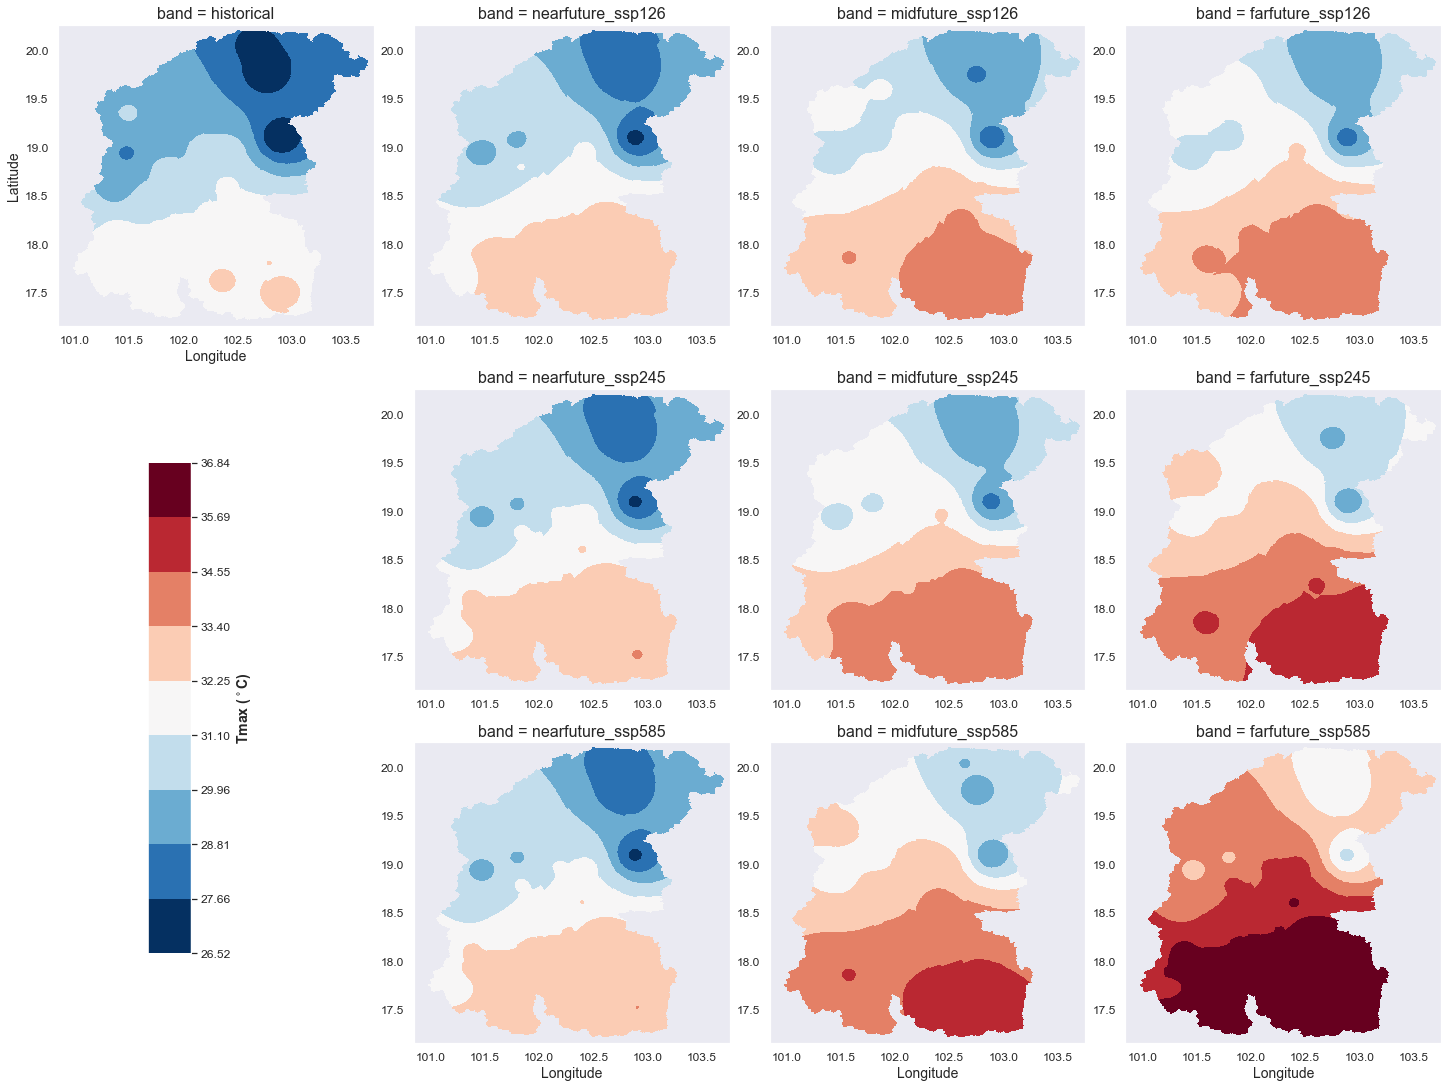

In [99]:
#final_processed_ds= final_processed_ds.drop('spatial_ref')
#set fontsize
from tqdm import tqdm
import matplotlib
font = {'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#plt.rcParams['font.size']=10


fig, axes= plt.subplots(ncols=4, nrows=3, figsize=(20,15), constrained_layout =True)
axes_names= xr_tasmax.band.values
gs=axes[0,0].get_gridspec()
print(gs)
for ax in axes[1:,0]:
    ax.remove()
bigax=fig.add_subplot(gs[1:,0])
bigax.set_visible(False)

new_ax_names=axes_names.tolist()
for pos in [4, 8]:
    new_ax_names.insert(pos,'em')
new_ax_names

axes_dict={name: ax for name, ax in zip(new_ax_names, axes.flatten())}
new_axs_list=[]
cbar_ax= fig.add_axes([0.1,0.098, 0.03,0.5])

for p, ax in tqdm(axes_dict.items(), desc='running subpots'):
    if p!='em':
        plotd=xr.plot.pcolormesh(xr_tasmax.sel(band=p), x='x', y='y', vmin= xr_tasmax.min(),vmax=xr_tasmax.max(), ax=ax,add_colorbar=False, cmap='RdBu_r', levels=10)
        new_axs_list.append(ax)
        
    if p=='historical' :
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_ylabel('Latitude', fontsize=14)
    elif 'ssp585' in p:
        ax.set_xlabel('Longitude', fontsize=14)
        ax.set_ylabel('')
    elif p=='near_future_ssp245':
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
cb=fig.colorbar(plotd, cax=cbar_ax, ax= new_axs_list, aspect=50, extend='both', cmap='RdBu_r', fraction=0.05, anchor=(1,0.5))
cb.set_label(label='Tmax ($^\circ$C)', size=14, weight='bold')